# <h1><center>Netflix Customer Profile Analysis</center></h1>

# <center>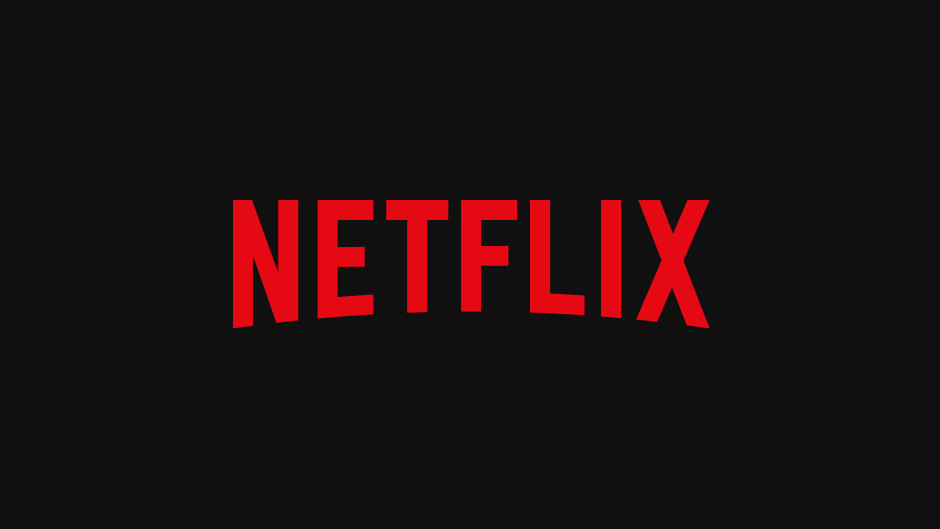
</center>

# Introduction

:First of all, what is Netflix? To those who don't know Netflix is a subscription based streaming service that allows its members to watch all sorts of movies and TV shows on the internet. According to this article on [BackLinko](https://backlinko.com/netflix-users), as of April 2024, Netflix has a total of 260.28 million subscribers.

Netflix has multiple subscription plans, each tier of subscription grants members more services such as no ads, amount of devices they can have their account on or HD access. From Netflix's own [website](https://help.netflix.com/en/node/24926), the tiers of subscription goes as follows: Basic (known as standard with ads), standard, and premium.

Through Kaggle, a database filled with datasets, I obtained a dataset titled, [Netflix Userbase Dataset](https://www.kaggle.com/datasets/arnavsmayan/netflix-userbase-dataset/data). The dataset consists of features such as subscription type, user age, last payment, etc.

### Reasoning For Dataset and Goals

A question that you may ask is, why choose this dataset? What makes this dataset stand out from any other dataset that involves Netflix?

Well, one of the reasons why I chose this dataset over any other dataset that deals with Netflix's user base is because it has a fairly large amount of data that can be used for analysis. I believe that is contains enough data for use to find correlations within my variables. With this dataset, I have a lot of different opportunities to analyze it.

With that being said, for this specific data anaylze, I am really interested in the demographic of the Netflix user base. Out of all the features of the dataset, I want to analyze the relationship between the demographic of Netflix users and their likelihood in choosing a certain subscription plan. I want to know if variables such as age is more likely to stick with a Netflix subscription plan compared to other variables.

The main question I want to delve into throughout this data analysis is,

***Which demographic is more likely to opt into Netflix's more expensive monthly subscription system?***

By the end of this data analysis, I hope to answer this main question and to make a report of all the findings.



# Section 1: Data Curation
Before I start with the data analysis, I am going to clean out the dataset. The reason why I do this is to first simplify the dataset. Irrelevant data will make the dataset feel cluttered and may cause confusion. Thus, to keep things simple unnecessary data is removed. Removing null data also accomplishes the same goal, but it also helps with preventing the data analysis results from being skewed.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import chi2_contingency
from scipy.stats.contingency import crosstab
import seaborn as sns
from datetime import datetime
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics

Setting up the dataframe to contain the Netflix Userbase dataset.



In [ ]:
netflix_df = pd.read_csv("Netflix Userbase.csv")

# Dropping empty data
netflix_df = netflix_df.dropna()

To keep everything organized and standardized, the dates within the 'Join Date'

*   List item
*   List item

Last Payment Date' columns are joined first to ISO 8601.

In [ ]:
#need to specifiy format because default format doesn't fit
netflix_df['Join Date'] = pd.to_datetime(netflix_df['Join Date'],format="%d-%m-%y",exact=True)
netflix_df['Last Payment Date'] = pd.to_datetime(netflix_df['Last Payment Date'],format="%d-%m-%y",exact=True)

Moving on, the irrelevant columns were dropped as they aren't really significant to the analysis.

In [ ]:
# Dropping irrelevant columns
netflix_df = netflix_df.drop(columns=['Plan Duration'])

Since I want to know which age group is willing to stay with their monthly description, I created a new column called subscription length. This column will take the difference between the user's last payment and the start of the user's subscription. This will tell us how long the user has been with Netflix's subscription system.

In [ ]:
# Calculating user subscription length
days = (netflix_df['Last Payment Date'] - netflix_df['Join Date']).dt.days
netflix_df['Subscription Length (in days)'] = days

I also made another column called 'Total User Revenue', which represents the total revenue from users based on their subscription type and length.

In [ ]:
#calculate total revenue for each individuals based on Subscription Length
revenue=(round(netflix_df['Monthly Revenue'] * netflix_df['Subscription Length (in days)']/30, 2))
netflix_df['Total User Revenue']=revenue

#find last payment date and first join date
last_payment_dates= list(set(netflix_df['Last Payment Date']))
last_payment_dates.sort()
last_payment_date= last_payment_dates[-1]

Join_dates=list(set(netflix_df['Join Date']))
Join_dates.sort()
first_join_date= Join_dates[0]

I also want to put each user in an age group, so I made another new column for that. The first age group starts at 25 years old and the final age group ends with 55 years old. Each group contains ages within 5 years. Here are all the possible age groups:
*   Ages 25-29
*   Ages 30-34
*   Ages 35-39
*   Ages 40-44
*   Ages 45-49
*   Ages 50-54




In [ ]:
age_groups_str = [
    "25-29",
    "30-34",
    "35-39",
    "40-44",
    "45-49",
    "50-54"
  ]
bins = [25, 30, 35, 40, 45, 50, 55]
netflix_df['Age Group'] = pd.cut(netflix_df['Age'], bins=bins, labels=age_groups_str, right=False)

Converting String data into numerical data using one hot encoding

In [ ]:
# For Gender
netflix_df_dummy = pd.get_dummies(netflix_df['Gender'])
netflix_df = pd.concat([netflix_df, netflix_df_dummy], axis=1).reindex(netflix_df.index)
netflix_df.drop('Gender', axis=1, inplace=True)

# For Country
netflix_df_dummy = pd.get_dummies(netflix_df['Country'])
netflix_df = pd.concat([netflix_df, netflix_df_dummy], axis=1).reindex(netflix_df.index)
netflix_df.drop('Country', axis=1, inplace=True)

# For device
netflix_df_dummy = pd.get_dummies(netflix_df['Device'])
netflix_df = pd.concat([netflix_df, netflix_df_dummy], axis=1).reindex(netflix_df.index)
netflix_df.drop('Device', axis=1, inplace=True)

This is the final dataset after processing:




In [ ]:
netflix_df

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Age,Subscription Length (in days),Total User Revenue,Age Group,Female,...,Germany,Italy,Mexico,Spain,United Kingdom,United States,Laptop,Smart TV,Smartphone,Tablet
0,1,Basic,10,2022-01-15,2023-06-10,28,511,170.33,25-29,False,...,False,False,False,False,False,True,False,False,True,False
1,2,Premium,15,2021-09-05,2023-06-22,35,655,327.50,35-39,True,...,False,False,False,False,False,False,False,False,False,True
2,3,Standard,12,2023-02-28,2023-06-27,42,119,47.60,40-44,False,...,False,False,False,False,True,False,False,True,False,False
3,4,Standard,12,2022-07-10,2023-06-26,51,351,140.40,50-54,True,...,False,False,False,False,False,False,True,False,False,False
4,5,Basic,10,2023-05-01,2023-06-28,33,58,19.33,30-34,False,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,Premium,14,2022-07-25,2023-07-12,28,352,164.27,25-29,True,...,False,False,False,True,False,False,False,True,False,False
2496,2497,Basic,15,2022-08-04,2023-07-14,33,344,172.00,30-34,True,...,False,False,False,True,False,False,False,True,False,False
2497,2498,Standard,12,2022-08-09,2023-07-15,38,340,136.00,35-39,False,...,False,False,False,False,False,True,True,False,False,False
2498,2499,Standard,13,2022-08-12,2023-07-12,48,334,144.73,45-49,True,...,False,False,False,False,False,False,False,False,False,True


# Section 2: Exploratory Data Analysis

## Examining Revenue from Different Age Groups

In [ ]:
# Mean, Max, min, standard deviation, number of bins
mean_age = netflix_df['Age'].mean()
median_age = netflix_df['Age'].median()
largest_age = netflix_df['Age'].max()
smallest_age = netflix_df['Age'].min()
first_quartile_age = np.percentile(netflix_df['Age'], 25)
third_quartile_age = np.percentile(netflix_df['Age'], 75)
standard_dev_age = np.std(netflix_df['Age'])

print("Attributes of Netflix Userbase Dataset:")
print("Maximum age: ", largest_age)
print("Minimum age: ", smallest_age)
print("Median age: ", int(median_age))
print("25th Quartile: ", int(first_quartile_age))
print("75th Quartile: ", int(third_quartile_age))
print("Average age: ", mean_age)
print("Standard Deviation: ", standard_dev_age)

Attributes of Netflix Userbase Dataset:
Maximum age:  51
Minimum age:  26
Median age:  39
25th Quartile:  32
75th Quartile:  45
Average age:  38.7956
Standard Deviation:  7.1703431326541125


From the Netflix Userbase dataset, we can see that the maximum age is 51 years old and the minimum age is 26 years old. The median age is 39 years old, with the 25th and 75th quartiles being 32 years old and 45 years old. The mean age is 39 years old and the standard deviation being about 7 years.

Based on the attributes I obtained from the datasets, there does not appear to be any outliers.

The minimum age of 26 years old is close to the 25th quartile, being within one standard deviation. Looking at the maxiumum age of 51 years old, we can again see that it is within one standard deviation of 75th quartile.

Next, looking at both the mean and median values, we can see that they are extremely close to each other. With a mean of 38.8 years old and median of 39 years old, The data is not skewed and is close to symmetrical.

Text(0.5, 0, 'Age')

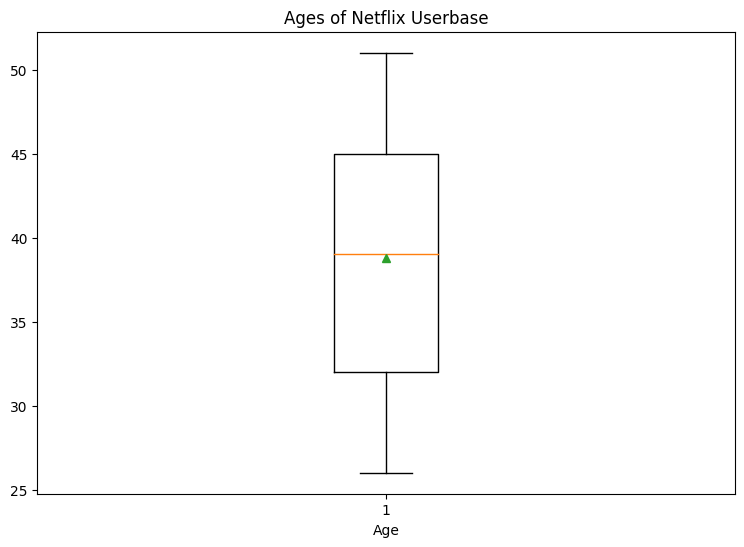

In [ ]:
# Creating a boxplot
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()
bp = ax.boxplot(netflix_df['Age'], showmeans=True)

# Labels and title
plt.title("Ages of Netflix Userbase")
plt.xlabel("Age")

Observing the box plot above, there appears to be no outliers. Also, as stated previously, the mean and median are extremely close to each other, indicating little to no skewness.

Below is a histogram to further illustrate the distribution of age within the dataset.

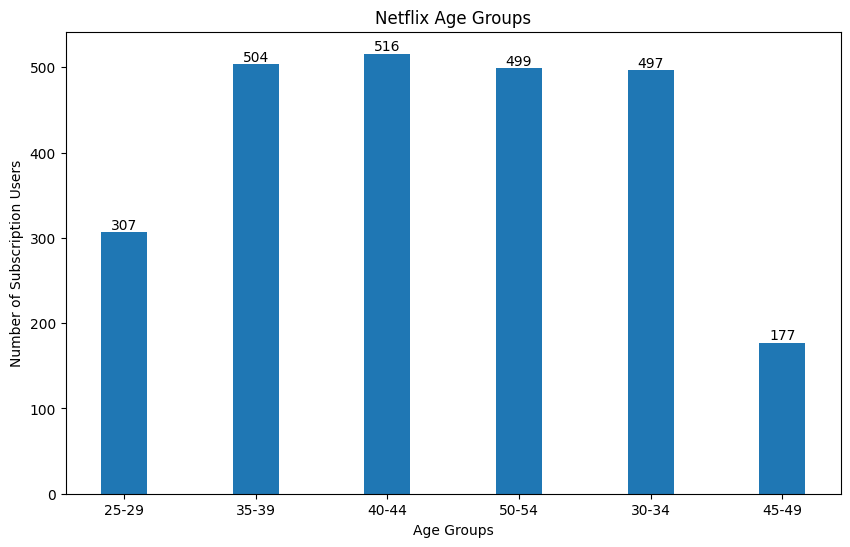

In [ ]:
# Counting number of users within each age group
age_group_count = []
netflix_df.groupby('Age Group')['Age Group'].apply(lambda z: age_group_count.append(z.count()))

# Ticks
x = np.arange(len(netflix_df['Age Group'].unique()))

# Plotting
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(x, age_group_count, width=.35, label='Users')

# Labels and title
plt.xlabel('Age Groups')
plt.ylabel('Number of Subscription Users')
plt.title('Netflix Age Groups')
ax.set_xticks(x)
ax.set_xticklabels(netflix_df['Age Group'].unique())

# Bar labels
for container in ax.containers:
  ax.bar_label(container)

Looking at the histogram above, I can see that there are various peaks. And I can also see that there is little to no skewness in the data.

Now the total monthly revenue can be calculated from each age group, along with how much revenue came from each age group based on each user's subscription length.

In [ ]:
monthly_revenues = []

# Calculate Monthly Revenue from those still subscribed in 2023/7
last_payment_month = datetime.strptime(str(last_payment_date.year)+"/" + str(last_payment_date.month), "%Y/%m")

monthly_revenue = netflix_df['Monthly Revenue'].sum()
mon_rev_age_group = netflix_df[(netflix_df['Last Payment Date']>=last_payment_month)].groupby('Age Group')['Monthly Revenue']
print("Monthly Revenue from Each Age Group (as of 2023/7):")
print(mon_rev_age_group.apply(lambda x : '${:,.2f}'.format(x.sum())))

# Adding all Monthly Revenue based on Age group to a list
add_to_list = mon_rev_age_group.apply(lambda y : monthly_revenues.append(y.sum()))

sum = 0
for i in monthly_revenues:
  sum+=i
print("Total monthly revenue:", '${:,.2f}'.format(sum))
print()

#for calculating total revenue, include those no longer subscribed
def calculate_total_revenue(a,b):
  return netflix_df[(netflix_df['Age'] >= a) & (netflix_df['Age'] < b)]['Total User Revenue'].sum()

print("Total revenues based on Age group, from "+
      str(first_join_date.year) + "\\"+ str(first_join_date.month)+ " to "
      + str(last_payment_date.year)+"\\" + str(last_payment_date.month)+": ")
for idx in range(0, len(age_groups_str)):
  age_range=age_groups_str[idx].split('-')
  print(age_groups_str[idx] + ": ", end="")
  revenue = calculate_total_revenue(int(age_range[0]),int(age_range[1]))
  print('${:,.2f}'.format(revenue))
print("Total User Revenue:", '${:,.2f}'.format(netflix_df['Total User Revenue'].sum()))

Monthly Revenue from Each Age Group (as of 2023/7):
Age Group
25-29    $2,341.00
30-34    $4,163.00
35-39    $4,072.00
40-44    $4,334.00
45-49    $3,999.00
50-54    $1,533.00
Name: Monthly Revenue, dtype: object
Total monthly revenue: $20,442.00

Total revenues based on Age group, from 2021\9 to 2023\7: 
25-29: $25,855.29
30-34: $53,527.89
35-39: $51,013.53
40-44: $52,922.50
45-49: $51,365.66
50-54: $22,897.35
Total User Revenue: $321,674.55


Here is a pie chart of the revenues, divided by age groups.

Text(0, 0.5, 'Netflix Monthly Revenues')

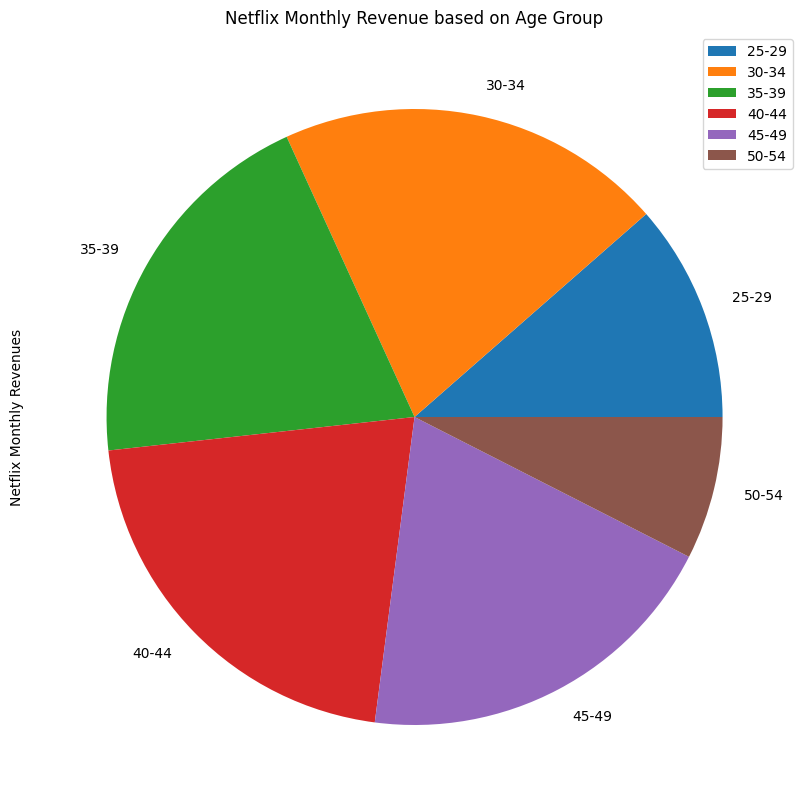

In [ ]:
df = pd.DataFrame({'revenues': monthly_revenues}, index=age_groups_str)
pie_chart = df.plot.pie(y='revenues', figsize=(10,10))

plt.title("Netflix Monthly Revenue based on Age Group")
plt.ylabel("Netflix Monthly Revenues")

With a monthly revenue of $20,442.00, the highest contributing age groups are 30-34,35-39, 40-44, and 45-49 years old. Together they make up around two-thirds of the entire Netflix revenue. This makes sense because looking back to the histogram showing the age distribution of the Netflix Userbase dataset, we can see that peaks are located close to the highest contributing groups.

Based on these observations, it can be concluded that after analyzing the dataset, the age groups that are most likely to purchase a Netflix subscription are from the age groups of 30-34, 35-39, 40-44 and 45-49. I came to this conclusion after looking at the age distributions and revenues coming from these age groups.

### Hypothesis Testing on Subscription Type and Age Group

There are different tiers when it comes to a Netflix subscription. They go from the order from lowest to highest tier: Basic, standard, and premium. Previously I concluded that there exists a range of age groups that are most likely to purchase a Netflix subscription. Now I want to explore whether the tier of Netflix subscription depends on age group.

To do this I will be doing hypothesis testing. A significance level of 0.05 will be used. The Chi-square test will be used since there are three subcategories within 'Subscription Type'. They are basic, standard and premium. Also, I chose Chi-Square test since we are dealing with discrete and categorical data.

First the categorical data needs to be converted into numerical data.

In [ ]:
contingency_table = pd.crosstab(netflix_df['Age Group'], netflix_df['Subscription Type'])
contingency_table

Subscription Type,Basic,Premium,Standard
Age Group,,,
25-29,123,98,86
30-34,197,155,152
35-39,222,138,156
40-44,180,148,171
45-49,208,142,147
50-54,69,52,56


Here are the Null Hypothesis and Alternative Hypothesis:

*   $H_0$: An individual's age group does affect their subscription type.
*   $H_a$: An individual's age group does not affect their subscription type.



In [ ]:
res = chi2_contingency(contingency_table)
res.pvalue

0.5172716325614647

Looking at the result from the Chi-Square test, it fails to reject the null hypothesis since the p-value is greater than the significance level of 0.05. What this means is that there is enough evidence to suggest that an individual's age group does have an effect on their subscription type.

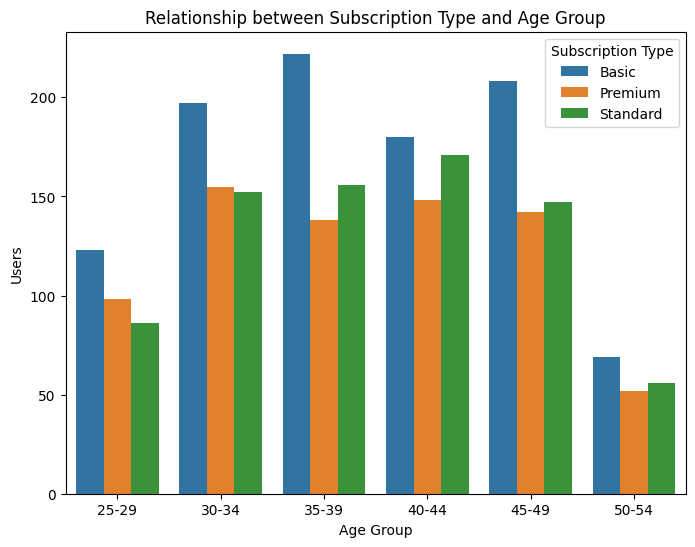

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=netflix_df, x='Age Group', hue='Subscription Type')
plt.title('Relationship between Subscription Type and Age Group')
plt.xlabel('Age Group')
plt.ylabel('Users')
plt.legend(title='Subscription Type')

### Correlation Analysis on Subscription Type and Age Group

The Pearson Correlation Coefficient for the Basic Subscription is: -0.19721483356756872
The Pearson Correlation Coefficient for the Premium Subscription is: -0.36393935481207457
The Pearson Correlation Coefficient for the Standard Subscription is: -0.34464787129857727


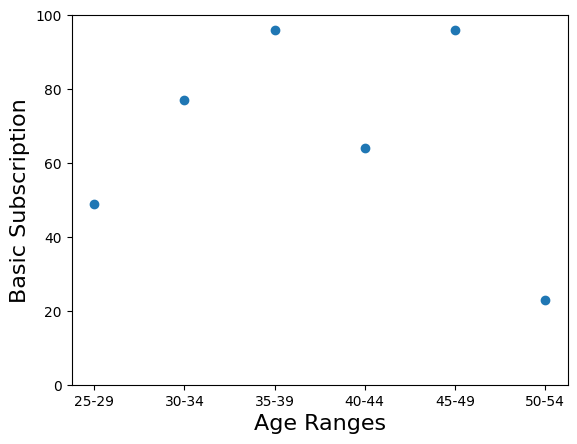

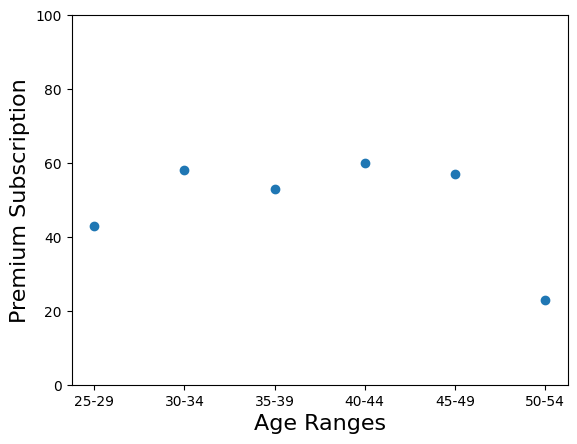

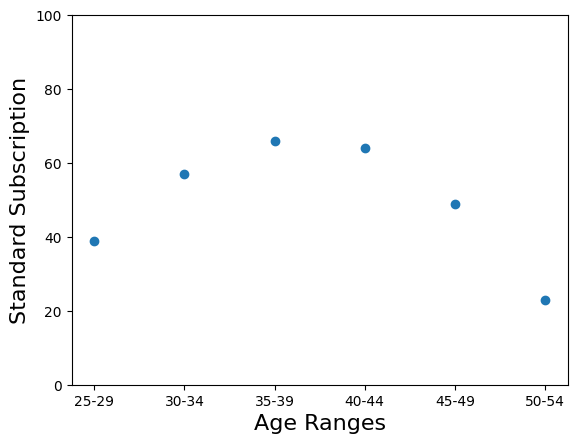

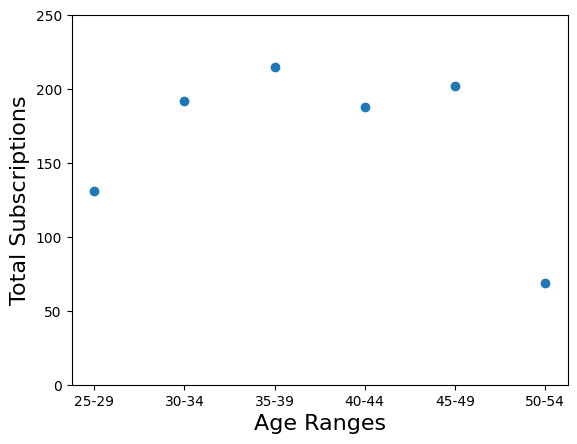

In [ ]:
age_range_mapping = {
    '25-29': 1,
    '30-34': 2,
    '35-39': 3,
    '40-44': 4,
    '45-49': 5,
    '50-54': 6
}

#graph for all subscription types
for subscription_type in list(netflix_df['Subscription Type'].unique()):
    Y_arr = []  # subscription count for each age group, only counting those still subscribed
    x = age_groups_str

    for age_group in x:
        Y_arr.append(len(netflix_df[(netflix_df['Subscription Type'] == subscription_type) & (netflix_df['Age Group'] == age_group) & (netflix_df['Last Payment Date'] <= last_payment_month)]))

    fig, ax = plt.subplots()
    ax.scatter(x, Y_arr)
    ax.set_xlabel('Age Ranges', fontsize=16)
    ax.set_ylabel('{} Subscription'.format(subscription_type), fontsize=16)
    ax.set_ylim(0,100)

    numerical_x = [] #numerical representation for age group

    for age_group in x:
        numerical_age = age_range_mapping[age_group]
        numerical_x.append(numerical_age)

    x = np.array(numerical_x)

    Y_arr = np.array(Y_arr)

    correlation_coefficient = np.corrcoef(Y_arr, x)[0, 1]
    print("The Pearson Correlation Coefficient for the {} Subscription is: {}".format(subscription_type, correlation_coefficient))

#total subscription graph
Y_arr = []  # subscription count for each age group, only counting those still subscribed
x = age_groups_str

for age_group in x:
    Y_arr.append(len(netflix_df[(netflix_df['Age Group'] == age_group) & (netflix_df['Last Payment Date'] <= last_payment_month)]))

fig, ax = plt.subplots()
ax.scatter(x, Y_arr)
ax.set_xlabel('Age Ranges', fontsize=16)
ax.set_ylabel('Total Subscriptions', fontsize=16)
ax.set_ylim(0,250)


plt.show()

The Pearson Correlation Coefficient for the Basic Subscription is: -0.19721483356756872
The Pearson Correlation Coefficient for the Premium Subscription is: -0.36393935481207457
The Pearson Correlation Coefficient for the Standard Subscription is: -0.34464787129857727


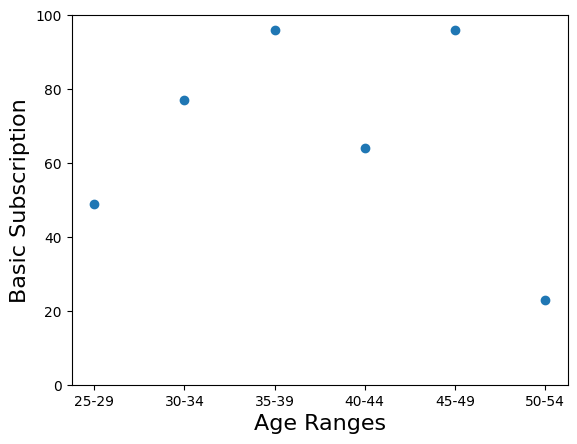

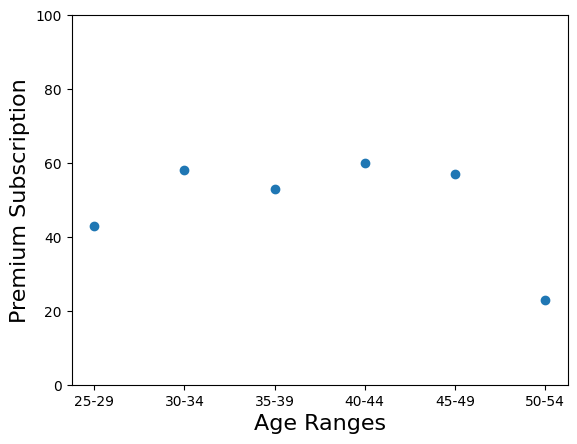

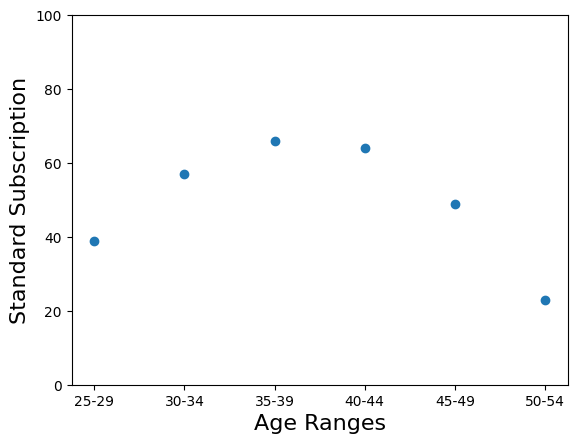

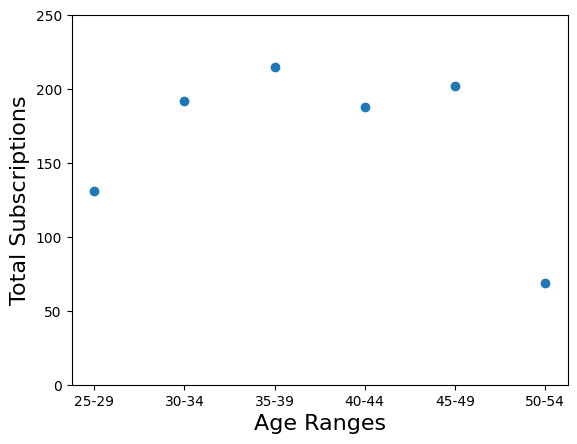

In [ ]:
age_range_mapping = {
    '25-29': 1,
    '30-34': 2,
    '35-39': 3,
    '40-44': 4,
    '45-49': 5,
    '50-54': 6
}

#graph for all subscription types
for subscription_type in list(netflix_df['Subscription Type'].unique()):
    Y_arr = []  # subscription count for each age group, only counting those still subscribed
    x = age_groups_str

    for age_group in x:
        Y_arr.append(len(netflix_df[(netflix_df['Subscription Type'] == subscription_type) & (netflix_df['Age Group'] == age_group) & (netflix_df['Last Payment Date'] <= last_payment_month)]))

    fig, ax = plt.subplots()
    ax.scatter(x, Y_arr)
    ax.set_xlabel('Age Ranges', fontsize=16)
    ax.set_ylabel('{} Subscription'.format(subscription_type), fontsize=16)
    ax.set_ylim(0,100)

    numerical_x = [] #numerical representation for age group

    for age_group in x:
        numerical_age = age_range_mapping[age_group]
        numerical_x.append(numerical_age)

    x = np.array(numerical_x)

    Y_arr = np.array(Y_arr)

    correlation_coefficient = np.corrcoef(Y_arr, x)[0, 1]
    print("The Pearson Correlation Coefficient for the {} Subscription is: {}".format(subscription_type, correlation_coefficient))

#total subscription graph
Y_arr = []  # subscription count for each age group, only counting those still subscribed
x = age_groups_str

for age_group in x:
    Y_arr.append(len(netflix_df[(netflix_df['Age Group'] == age_group) & (netflix_df['Last Payment Date'] <= last_payment_month)]))

fig, ax = plt.subplots()
ax.scatter(x, Y_arr)
ax.set_xlabel('Age Ranges', fontsize=16)
ax.set_ylabel('Total Subscriptions', fontsize=16)
ax.set_ylim(0,250)

plt.show()

As shown above the Pearson Correlation Coefficient for all three types of subscription is negative, which means that age has a negative correlation with subscription type. The coefficient for standard subscription type is ~(-.20) which means that the correlation between this type and age is weak. The correlation coefficients for premium and standard type are ~(-0.36) and ~(-0.34), which means that there is a moderate correlation between age and these two subscription types. In other words, older age group is less likely to purchase standard and premium subscription, which is more expensive.
The graphs shows agreement to this as subscription for basic type is significantly more than other types.

# Section 3: Primary Analysis using Machine Learning

### Machine Learning Model Selection

As part of the machine learning data analysis, I want to compare three different Machine Learning models to see which model will best fit the dataset.
These models are the K-nearest Neighbors model, Random Forest Model, and Logisitic Regression

Below setting up the models, along with determining the input features (features used to predict the output feature) and the output features.

In [ ]:
# Here are the three models

netflix_models = {
    'Netflix KNN' : KNeighborsClassifier(),
    'Netflix Random Forest' : RandomForestClassifier(),
    'Netflix Logisitic Regression' : LogisticRegression()
}

excluded_features = ['Subscription Type', 'Laptop', 'Smart TV', 'Smartphone', 'Tablet', 'Monthly Revenue', 'Join Date', 'Last Payment Date', 'Total User Revenue', 'Subscription Length (in days)', 'User ID', 'Age Group']

# My input features
X = netflix_df.loc[:,(netflix_df.drop(columns=excluded_features)).columns]

# The target feature
y = netflix_df['Subscription Type']

Next the dataset is split between training dataset and testing dataset.

In [ ]:
# In order to have the results be consistent, a set seed of 6 will be used
seed = 6
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

The features here need to be standardized to prevent biases in the machine learning model.

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Now I start training each one of the ML models and see which one is best suited for the dataset.

In [ ]:
for model_name, model in netflix_models.items():
  model = model.fit(X_train_scaled, y_train)


Below is a report of each of the Netflix Models

In [ ]:
x_test_scaled = scaler.fit_transform(X_test)

for model_name, model in netflix_models.items():
  y_pred = model.predict(x_test_scaled)
  accuracy = accuracy_score(y_test, y_pred)

  print("Accuracy of " + model_name + ": " + str(accuracy))
  print(classification_report(y_test, y_pred, zero_division=1))
  print("-"*100)

Accuracy of Netflix KNN: 0.6066666666666667
              precision    recall  f1-score   support

       Basic       0.60      0.74      0.66       304
     Premium       0.50      0.48      0.49       219
    Standard       0.75      0.56      0.64       227

    accuracy                           0.61       750
   macro avg       0.62      0.59      0.60       750
weighted avg       0.62      0.61      0.60       750

----------------------------------------------------------------------------------------------------
Accuracy of Netflix Random Forest: 0.5786666666666667
              precision    recall  f1-score   support

       Basic       0.60      0.64      0.62       304
     Premium       0.46      0.46      0.46       219
    Standard       0.66      0.60      0.63       227

    accuracy                           0.58       750
   macro avg       0.58      0.57      0.57       750
weighted avg       0.58      0.58      0.58       750

---------------------------------------

### Analysis of Netflix Models Classification Report

I used the KNN, Random Forest, and the Logistic Regression Models to ultimately see which Machine Learning model best suited the Netflix data.

The KNN Model, or the K-Nearest-Neighbors Model, has an accuracy of 0.6067. The KNN Model performed the best for the Basic subscription. Given an average f1 score of 60, this model performs reasonably well.

The Random Forest Model has an accuracy of 0.5773 and the performance seems relatiely more consistent with each of the subscription types. Given the f1 Score of 57, the Random Forest Model performs worse than the KNN Model, but would be considered an ok performance.

Lastly, the Logistic Regression is the most accurate Machine Learning Model with an accuracy of 0.6533. The model performed moderately well for the Premium and Basic subscription types and exceptionally well for the standard subscription type. It's interesting to see that the Standard subscription type has a precision of 0.98, which is practically ideal. Furthermore, the f1 score of the Logistic Regression is the greatest of the three, which shows that it performs well across the board with all of the different classes or subscription types.

Among the three machine learning models, the Logistic regression performs the best.

# Section 4: Visualization of Machine Learning Results

Since I know that the Logistic Regression ML model is more accurate than the other three ML models, I will use this ML model for the data analysis for the Netflix dataset.

Below is the corresponding confusion matrix for the Logistic Regression ML model,

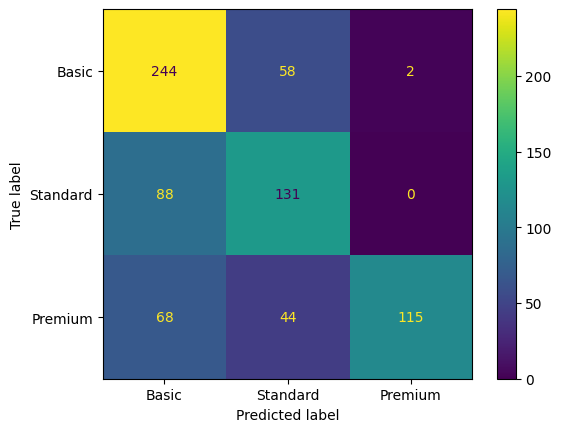

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Basic", "Standard", "Premium"])
cm_display.plot()
plt.show()

### Understanding the Confusion Matrix
This is a 3 by 3 confusion matrix, which may look confusing to read, but it is quite simple to understand. For more information on understanding to read this confusion matrix, visit the following website on [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/).

---

#### True Positives
According to the confusion matrix, this model was able to predict 244 instances correctly as basic subscription, 131 instances correctly as standard subscription, and 115 instances correctly as premium subscriptions. This makes up the true positives.

---
#### False Negatives

Moving on to the false negatives, 60 instances were incorrectly labeled as not basic subscription when in fact the data was basic subscription. 88 instances were incorrectly predicted as not premium subscriptions when in fact it was. And finally 112 instances were incorrectly predicted as not premium subscription when it was.

---
#### False Positives

For the false positives, 156 instances were predicted as either premium or standard when in fact it was basic subscription. 102 instances were either predicted as basic or premium when the actual label was standard subscription. And finally 2 instances were predicted as either basic or standard when the actual label was premium subscription

---
#### True Negatives
For the basic subscription, 290 instances were correctly identified as not classified as basic subscription. For the standard subscription, 429 instances were correctly classified as not standard subscription. And finally 521 instances were correctly identified as not premium subscription.

---
#### Summary of the Confusion Matrix
Reflecting back at the previous classification report, the 65% prediction accuracy makes sense as when examining the confusion matrix, I had almost double the amount of correct predictions when compared to the number of incorrect predictions.

### Logistic Regression Coefficients

In logisitic regression, the coefficient determines the effect of one unit change in the predictor variable. The higher the coefficient the more significant the feature is in classifying the data instance.

In [ ]:
coefficients = netflix_models.get("Netflix Logisitic Regression").coef_[0]
feature_names = X.columns.tolist()

# Printing each feature and their coefficient
for idx in range(len(feature_names)):
  print("Feature name:", feature_names[idx])
  print("Coefficient:", coefficients[idx])
  print()


Feature name: Age
Coefficient: -0.0026737134511879037

Feature name: Female
Coefficient: 0.0024725843802260047

Feature name: Male
Coefficient: -0.0024725843802260047

Feature name: Australia
Coefficient: -0.2769725177940294

Feature name: Brazil
Coefficient: 0.2687226991592011

Feature name: Canada
Coefficient: -0.02105422655763505

Feature name: France
Coefficient: 0.15721120005667713

Feature name: Germany
Coefficient: 0.34851649337659213

Feature name: Italy
Coefficient: 0.5670274424359272

Feature name: Mexico
Coefficient: -0.2041690135042585

Feature name: Spain
Coefficient: -0.3288469223673286

Feature name: United Kingdom
Coefficient: -0.2536919887037634

Feature name: United States
Coefficient: -0.06761370138309171



Now I find the most significant feature from the dataset,

In [ ]:
most_significant_feature_index = max(range(len(coefficients)), key=lambda i: abs(coefficients[i]))
most_significant_feature_name = feature_names[most_significant_feature_index]

print("Most Significant Feature:", most_significant_feature_name)
print("Coefficient:", coefficients[most_significant_feature_index])

Most Significant Feature: Italy
Coefficient: 0.5670274424359272


Since Italy has a coefficient of .56, it means that is the most significant feature in the dataset in predicting the subscription type.

# Section 5: Insights and Conclusion



Based on the above models and analysis:
*   The older population are more likely to buy subscriptions that are less expensive.
*   The three country with customers most likly to purchase more expensive subscriptions are: Italy, Germany, and Brazil.
*   The customers in Spain, Australia, and United Kingdom are least likely to purchase more expensive subscriptions.

From these analysis, it can be concluded that the demography most likely to purchase the more expensive subscription are the younger customers from Italy, Germany, or Brazil.

If I was to expand the topic further, the next goal would be analyzing the total and monthly revenue for the demography and how they change over time. These analysis would give insight into the change of Netflix's popularity and revenue in different demographic.



In [ ]:
# Remove this part after creating html
%%shell
jupyter nbconvert --to html /content/CMSC320_Final_Project.ipynb

[NbConvertApp] Converting notebook /content/CMSC320_Final_Project.ipynb to html
[NbConvertApp] Writing 1119759 bytes to /content/CMSC320_Final_Project.html
